In [58]:
import pandas as pd
import numpy as np
from pylab import rcParams
import datetime as dt
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import matplotlib.dates as mdates 

from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from collections import Counter

In [59]:
class Stats:
        
    
    def newVariables(df):
        #calculates the percentage of COVID tests that came back as positive for a single day.
        df['positivityRate%'] = (df['positiveIncrease']/df['totalTestResultsIncrease'])*100
        #calculates the total amount of COVID deaths in the previous seven days
        df['deathIncreaseSevenDay'] = df['deathIncrease'].rolling(7).sum().shift(-6)
        #calculates the average amount of COVID deaths in the previous seven days
        df['deathIncreaseSDRA'] = df['deathIncrease'].rolling(7).mean().shift(-6)
        #calculates the amount of positive cases divided by the amount of COVID deaths
        df['caseFatalityRate'] = df['death'] / df['positive']
        #calculates the average weekly death toll among the last five weeks 
        df['7 day total avg 5w'] = df['deathIncreaseSevenDay'].rolling(5).mean().shift(-4)
        #calculates the percentage that the death increase seven day rolling average changed
        df['% increase diSDRA'] = 100 * round(df['deathIncreaseSDRA']/df['deathIncreaseSDRA'].shift(-1) - 1, 3)
        #calculates the percentage that the average weekly death toll among the last five weeks changed
        df['% increase diSD'] = 100 * round(df['7 day total avg 5w']/df['7 day total avg 5w'].shift(-1) - 1, 3)
        #calculates the percentage that the percent change of the death increase seven day rolling average changed
        df['% increase %i diSDRA'] = 100 * round(df['% increase diSDRA']/df['% increase diSDRA'].shift(-1) - 1, 3)
        #calculates the seven day rolling average of new cases
        df['positiveIncreaseSDRA'] = df['positiveIncrease'].rolling(7).mean().shift(-6)
        #converts the date to a more human-friendly format
        df['date'] = [datetime.strptime(str(x), '%Y%m%d').strftime('%m/%d/%Y') for x in df['date']]
        return df

    def stateCsv(state):
        df = pd.read_csv(f"https://api.covidtracking.com//v1/states/{state}/daily.csv")
        df = Stats.newVariables(df)
        return df
    
    def usaCsv():
        usa = pd.read_csv('https://api.covidtracking.com/v1/us/daily.csv')
        usa = Stats.newVariables(usa)
        return usa

    def world_csv_deaths(str):
        world_his_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
        df = world_his_deaths[(world_his_deaths['Country/Region'] == str) & world_his_deaths['Province/State'].isnull() ]
        return df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"],
                var_name="Date",
                value_name="Deaths")

    def world_csv_cases(str):
        world_his_cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
        df = world_his_cases[(world_his_cases['Country/Region'] == str) & world_his_cases['Province/State'].isnull() ]
        return df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"],
                    var_name="Date",
                    value_name="Cases")

    def worldCsv(str):
        df = Stats.world_csv_cases(str)
        df2 = Stats.world_csv_deaths(str)
        df['Deaths'] = df2['Deaths']
        df['CaseFatalityRate'] = df['Deaths']/df['Cases']
        return df

    def plotIt(area, column, mths, wks, ds):
        try:
            df = Stats.stateCsv(area)
            df = df[::-1]
        except:
            df = Stats.worldCsv(area)
            df['date'] = df['Date']
        finally:
            plt.figure(figsize = (18, 6))
            #Uses input of months, weeks, and days to determine the start date of the graph
            plt.plot(df.iloc[len(df['date'])-(mths*28 + wks*7 + ds):len(df['date'])]['date'] , 
                              df.iloc[len(df['date'])-(mths*28 + wks*7 + ds):len(df['date'])][column])
            #Modifies x-axis label size and frequency to increase legibility 
            plt.setp(plt.gca().xaxis.get_majorticklabels(),rotation=90)
            plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
            plt.gca().xaxis.set_minor_locator(mdates.DayLocator())
            plt.title(f"COVID {column} in {area.upper()}", size = 15)
            plt.xlabel('Date', size = 15)
            plt.ylabel(column, size = 15)
            plt.grid()
            plt.margins(0)
            plt.tight_layout()
            
    def plotOverlay(area, column1, column2, mths, wks, ds):
        try:
            df = Stats.stateCsv(area)
            df = df[::-1]
        except:
            df = Stats.worldCsv(area)
            df['date'] = df['Date']
        finally:
            plt.figure(figsize = (18, 5))
            #Modifies x-axis label size and frequency to increase legibility 
            plt.setp(plt.gca().xaxis.get_majorticklabels(),rotation=90)
            plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
            plt.gca().xaxis.set_minor_locator(mdates.DayLocator())
            plt.grid()
            plt.margins(0)
            #Uses input of months, weeks, and days to determine the start date of the graph
            plt.plot(df.iloc[len(df['date'])-(mths*28 + wks*7 + ds):len(df['date'])]['date'] , 
                              df.iloc[len(df['date'])-(mths*28 + wks*7 + ds):len(df['date'])][column1])

            plt.plot(df.iloc[len(df['date'])-(mths*28 + wks*7 + ds):len(df['date'])]['date'] , 
                              df.iloc[len(df['date'])-(mths*28 + wks*7 + ds):len(df['date'])][column2])
            #Creates legend based on the two input variables
            plt.title(f"COVID {column1} and {column2} in {area.upper()}", size = 15)
            plt.xlabel('Date', size = 15)
            plt.legend([column1, column2])
            
    def regressionLine(area, start_date, column):
        try:
            df = Stats.stateCsv(area)
        except:
            df = Stats.worldCsv(area)
            df['date'] = df['Date']
        finally:
            df = df.fillna(0)
            df['date'] = pd.to_datetime(df['date'])
            #Uses start_date input to convert the date variable into the amount of days starting from the date
            basedate = datetime.strptime(start_date, '%m/%d/%Y')
            x = df
            df['date'] = df.apply(lambda x: (x.date - basedate).days, axis=1)
            #Slices data so that it only contains data from the start date onwards
            df = df[df['date'] >= 0].reset_index()
            reg = linear_model.LinearRegression()
            reg.fit(df[['date']], df[column])
            %matplotlib inline
            r2 = "r2 = " + str(r2_score(df[column], reg.predict(df[['date']])))
            plt.scatter(df.date, df[column], color = 'red', marker = '+')
            plt.plot(df.date, reg.predict(df[['date']]), color = 'blue')
            
            try:
                plt.title(f"COVID {column} in {df['state'][0]}")
            except:
                plt.title(f"COVID {column} in {df['Country/Region'][0]}")
            plt.xlabel(f"Days since {basedate}")
            plt.ylabel(column)
            plt.grid()
            plt.margins(0)
            return f"r2 = {r2_score(df[column], reg.predict(df[['date']]) )}"
        
    def predictor(area, column, start_point, future_date):
        try:
            df = Stats.stateCsv(area)
        except:
            df = Stats.worldCsv(area)
            df['date'] = df['Date']
        finally:
            df = df.fillna(0)
            df['date'] = pd.to_datetime(df['date'])
            #Uses start_date input to convert the date variable into the amount of days starting from the date
            basedate = datetime.strptime(start_point, '%m/%d/%Y')
            x = df
            df['date'] = df.apply(lambda x: (x.date - basedate).days, axis=1)
            #Slices data so that it only contains data from the start date onwards
            df = df[df['date'] >= 0].reset_index()
            reg = linear_model.LinearRegression()
            reg.fit(df[['date']], df[column])
            value = datetime.strptime(future_date, '%m/%d/%Y') - basedate
            print(f"r2 = {r2_score(df[column], reg.predict(df[['date']]))}")
            return reg.predict([[value.days]])[0]


usa = Stats.usaCsv()
    

In [15]:
#National COVID tracking data pulled from covidtracking.com API, including custom variables
usa.head(15)

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hash,positivityRate%,deathIncreaseSevenDay,deathIncreaseSDRA,caseFatalityRate,7 day total avg 5w,% increase diSDRA,% increase diSD,% increase %i diSDRA,positiveIncreaseSDRA
0,03/07/2021,56,28756184.0,74582825.0,11808.0,40212.0,878613.0,8137.0,45475.0,2801.0,...,74952fef2e04125e96bbf3007726bc3e64a6a6d8,3.550319,11901.0,1700.142857,0.017914,12417.8,-1.8,-2.7,28.6,57856.428571
1,03/06/2021,56,28714654.0,74450990.0,11783.0,41401.0,877887.0,8409.0,45453.0,2811.0,...,21a596203ad2c78f4e54d1e69967caf126a2a5a7,4.193944,12113.0,1730.428571,0.017911,12756.2,-1.4,-3.0,-300.0,59687.714286
2,03/05/2021,56,28654639.0,74307155.0,12213.0,42541.0,877384.0,8634.0,45373.0,2889.0,...,a35ea4289cec4bb55c9f29ae04ec0fd5ac4e0222,3.943266,12280.0,1754.285714,0.017890,13154.8,0.7,-2.7,-106.8,61292.000000
3,03/04/2021,56,28585852.0,74035238.0,12405.0,44172.0,874603.0,8970.0,45293.0,2973.0,...,a19ad6379a653834cbda3093791ad2c3b9fab5ff,4.116132,12200.0,1742.857143,0.017855,13518.8,-10.3,-3.1,-inf,62159.142857
4,03/03/2021,56,28520365.0,73857281.0,11778.0,45462.0,873073.0,9359.0,45214.0,3094.0,...,9e1d2afda1b0ec243060d6f68a7134d011c0cb2a,4.750941,13595.0,1942.142857,0.017835,13946.0,0.0,-1.5,-100.0,63598.857143
5,03/02/2021,56,28453529.0,73590280.0,11196.0,46388.0,870901.0,9465.0,45084.0,3169.0,...,d09d1f506dacacd07f11102ddf356ffc29bbaeb6,4.037755,13593.0,1941.857143,0.017791,14156.8,-3.6,-1.9,-inf,64516.285714
6,03/01/2021,56,28399281.0,73334501.0,11748.0,46738.0,869030.0,9595.0,44956.0,3171.0,...,b8084497a1216c1ba4e391d7496b7c0ee669cffa,4.165829,14106.0,2015.142857,0.017764,14435.2,0.0,-0.5,-100.0,66638.714286
7,02/28/2021,56,28351189.0,73216424.0,11708.0,47352.0,868006.0,9802.0,44907.0,3245.0,...,c7cfdf3c2bf7472966bada1560de5d2d7a30277e,3.858858,14100.0,2014.285714,0.017750,14506.6,-1.6,-0.4,-23.8,67272.714286
8,02/27/2021,56,28296840.0,73012825.0,11731.0,48871.0,867127.0,10114.0,44875.0,3335.0,...,b1154e8002e47ec585f769adf5ceecaa53dc8cbb,4.304368,14336.0,2048.000000,0.017747,14559.4,-2.1,1.2,-4.5,67894.571429
9,02/26/2021,56,28225595.0,72807735.0,11945.0,51112.0,865699.0,10466.0,44791.0,3466.0,...,24286d9bbff64d4ff6b09301e75eac682dafc732,4.151091,14649.0,2092.714286,0.017727,14387.4,-2.2,1.9,-161.1,68053.000000


In [17]:
#Pulls the same data for individual states from the covidtracking.com API. Takes lowercase state abbreviations. 
Stats.stateCsv('il')

,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,...,grade,positivityRate%,deathIncreaseSevenDay,deathIncreaseSDRA,caseFatalityRate,7 day total avg 5w,% increase diSDRA,% increase diSD,% increase %i diSDRA,positiveIncreaseSDRA
0,03/07/2021,IL,1198335,NaN,NaN,NaN,totalTestsViral,18640190.0,1141.0,NaN,...,NaN,1.568420,279.0,39.857143,0.019205,283.0,-4.5,0.3,-158.4,1662.714286
1,03/06/2021,IL,1197267,NaN,NaN,NaN,totalTestsViral,18572096.0,1210.0,NaN,...,NaN,3.236675,292.0,41.714286,0.019212,282.2,7.7,2.8,-195.1,1688.571429
2,03/05/2021,IL,1194702,NaN,NaN,NaN,totalTestsViral,18492848.0,1166.0,NaN,...,NaN,1.395448,271.0,38.714286,0.019206,274.4,-8.1,0.1,-232.8,1576.428571
3,03/04/2021,IL,1193260,NaN,NaN,NaN,totalTestsViral,18389512.0,1200.0,NaN,...,NaN,2.351669,295.0,42.142857,0.019193,274.0,6.1,0.8,454.5,1719.142857
4,03/03/2021,IL,1191520,NaN,NaN,NaN,totalTestsViral,18315522.0,1260.0,NaN,...,NaN,2.602221,278.0,39.714286,0.019180,271.8,1.1,-2.1,-87.4,1739.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,03/08/2020,IL,6,NaN,NaN,44.0,totalTestsViral,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
365,03/07/2020,IL,6,NaN,NaN,44.0,totalTestsViral,NaN,NaN,NaN,...,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
366,03/06/2020,IL,5,NaN,NaN,35.0,totalTestsViral,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
367,03/05/2020,IL,5,NaN,NaN,27.0,totalTestsViral,NaN,NaN,NaN,...,NaN,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#Separate method is necessary for non-US countries. Takes whole word input. 
Stats.worldCsv('Germany')

,Province/State,Country/Region,Lat,Long,Date,Cases,Deaths,CaseFatalityRate
0,NaN,Germany,51.165691,10.451526,1/22/20,0,0,NaN
1,NaN,Germany,51.165691,10.451526,1/23/20,0,0,NaN
2,NaN,Germany,51.165691,10.451526,1/24/20,0,0,NaN
3,NaN,Germany,51.165691,10.451526,1/25/20,0,0,NaN
4,NaN,Germany,51.165691,10.451526,1/26/20,0,0,NaN
...,...,...,...,...,...,...,...,...
425,NaN,Germany,51.165691,10.451526,3/22/21,2678262,75009,0.028007
426,NaN,Germany,51.165691,10.451526,3/23/21,2699231,75255,0.027880
427,NaN,Germany,51.165691,10.451526,3/24/21,2722988,75484,0.027721
428,NaN,Germany,51.165691,10.451526,3/25/21,2744608,75669,0.027570


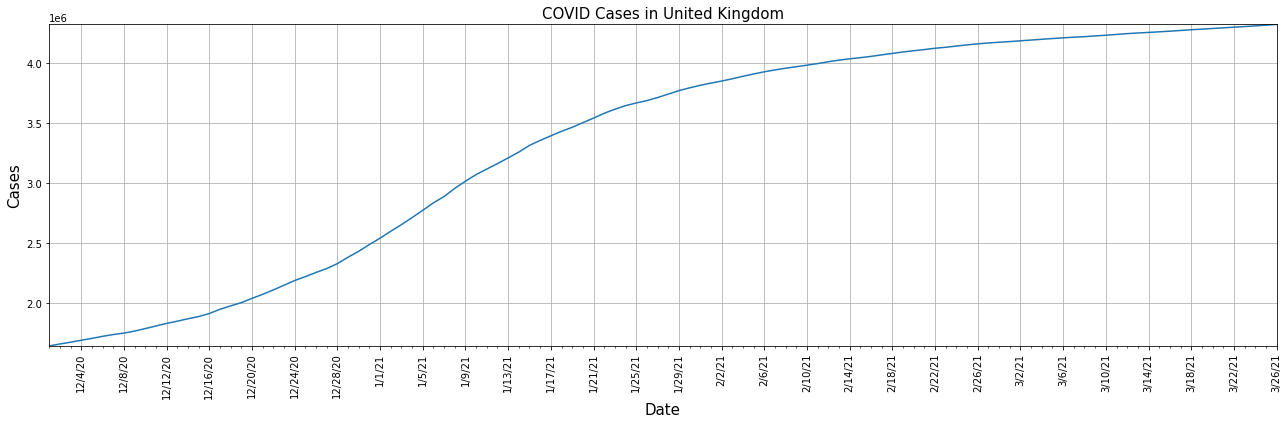

In [42]:
#Creates line graph of a single variable on a custom time frame input as months, weeks, and days ago.
Stats.plotIt('United Kingdom', 'Cases', 3, 4, 4)

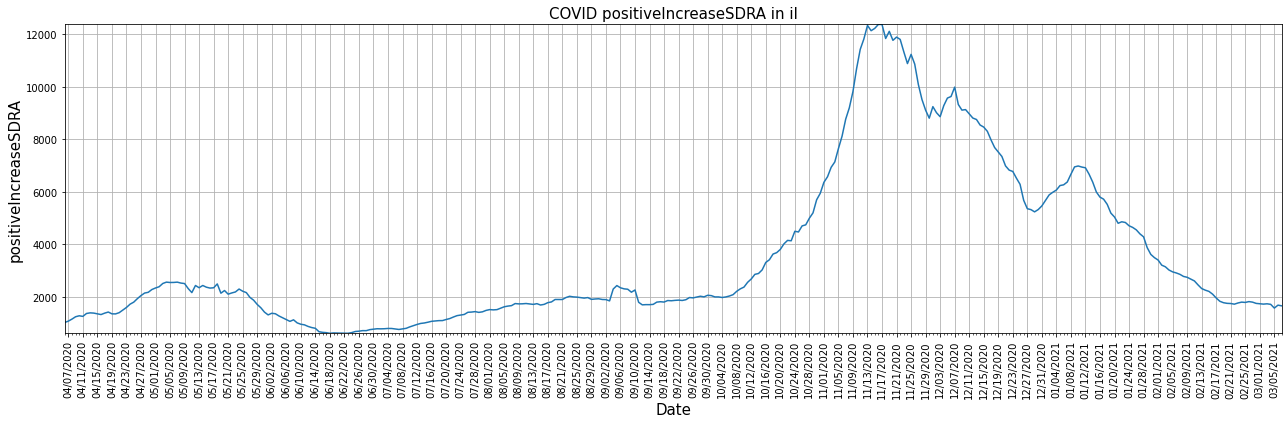

In [43]:
Stats.plotIt('il', 'positiveIncreaseSDRA', 12, 0, 0)

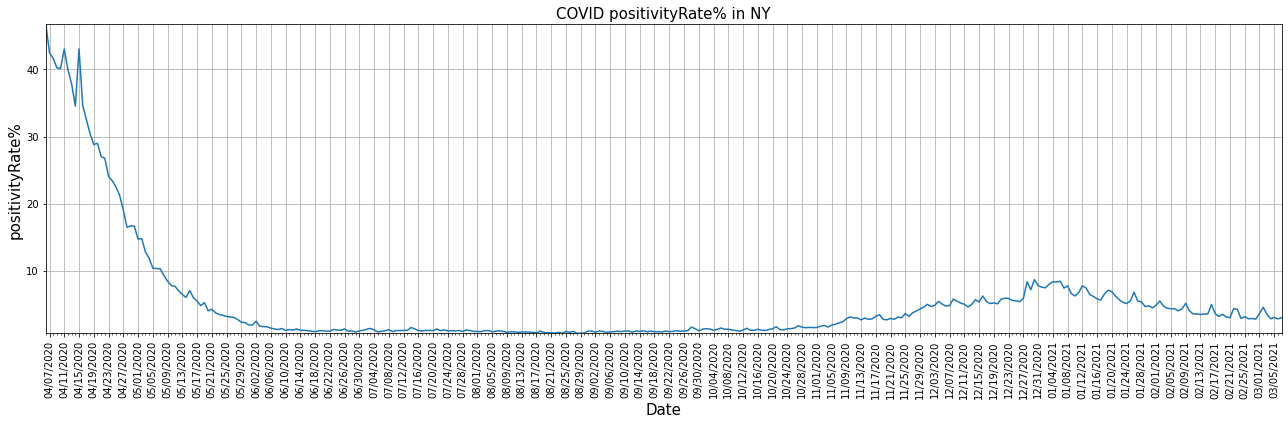

In [62]:
Stats.plotIt('ny', 'positivityRate%', 12, 0, 0)

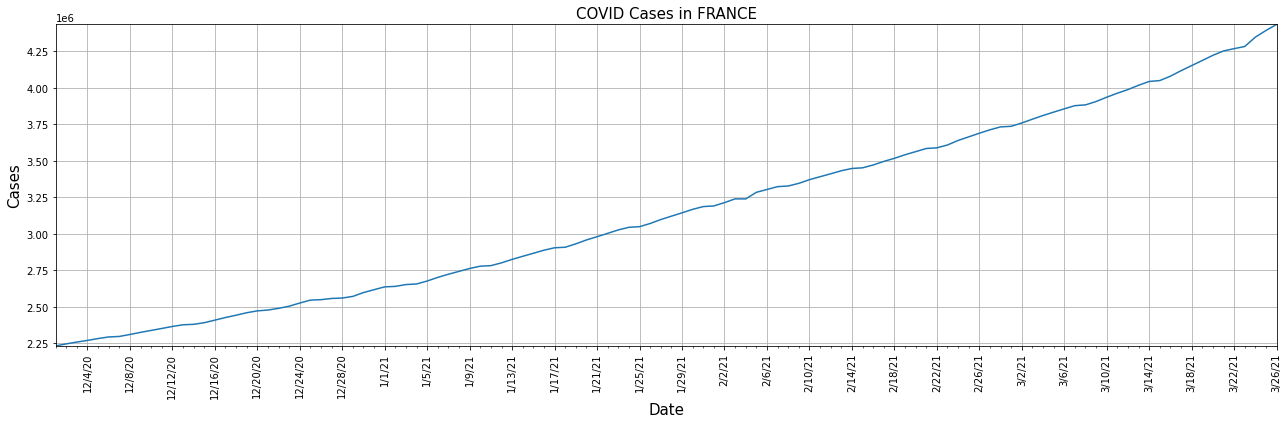

In [63]:
Stats.plotIt('France', 'Cases', 3, 4, 4)

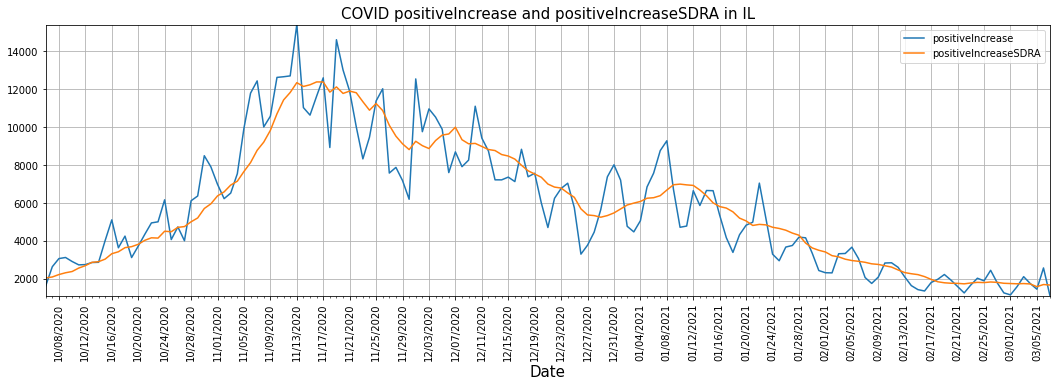

In [53]:
#Overlay two plots at a time to contextualize the rates of two variables using the same custom time frame as above.
Stats.plotOverlay('il', 'positiveIncrease', 'positiveIncreaseSDRA', 4, 5, 6)

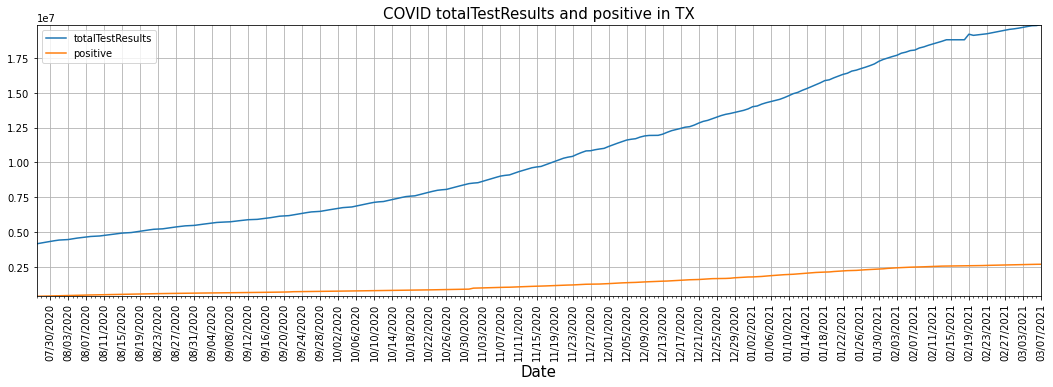

In [56]:
Stats.plotOverlay('tx', 'totalTestResults', 'positive', 8, 0, 0)

'r2 = 0.010291573140465693'

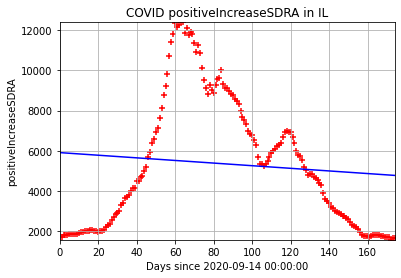

In [30]:
#Compute linear regressions to predict future rate of change of a variable. Change starting date to modify scope.
#Also display r2 score
Stats.regressionLine('il', '09/14/2020', 'positiveIncreaseSDRA')

'r2 = 0.3132440805094491'

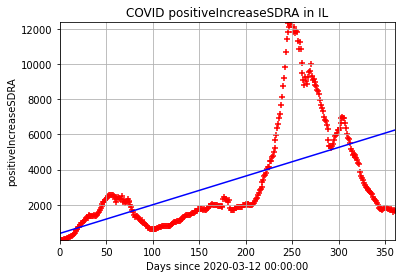

In [31]:
Stats.regressionLine('il', '03/12/2020', 'positiveIncreaseSDRA')

'r2 = 0.5390051536675322'

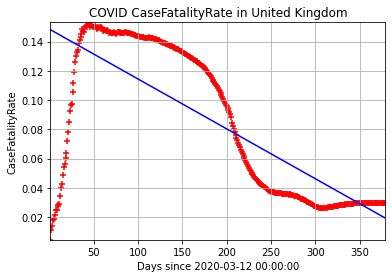

In [26]:
Stats.regressionLine('United Kingdom', '03/12/2020', 'CaseFatalityRate')

'r2 = 0.8108951336555298'

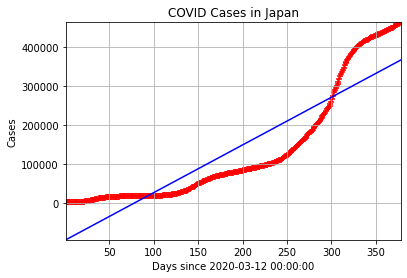

In [857]:
Stats.regressionLine('Japan', '03/12/2020', 'Cases')

In [57]:
#Creates simple predictions based on the linear regression formula. r2 score is also displayed.
#Prediction is based on the starting point input date. 
Stats.predictor('il', 'positive', '04/22/2020', '5/07/2021')

r2 = 0.8929039651835748


1372977.5107174504

In [64]:
Stats.predictor('il', 'positive', '02/22/2020', '5/07/2021')

r2 = 0.8753558475251892


1283808.765585442